# Import the Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load the Image Training and Validation Datasets

In [2]:
train_dataset_path = '/kaggle/input/riceleafs2/RiceLeafs2/train'
validation_dataset_path = '/kaggle/input/riceleafs2/RiceLeafs2/validation'

In [83]:
target_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,  
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)


validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dataset_path,
    shuffle=True,
    target_size=target_size,  
    batch_size=16,  
    class_mode='categorical'  
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dataset_path,
    shuffle=True,
    target_size=target_size, 
    batch_size=16, 
    class_mode='categorical' 
)

Found 80 images belonging to 4 classes.
Found 56 images belonging to 4 classes.


In [84]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : BrownSpot
1 : Healthy
2 : Hispa
3 : LeafBlast


# Plotting Sample Training Images

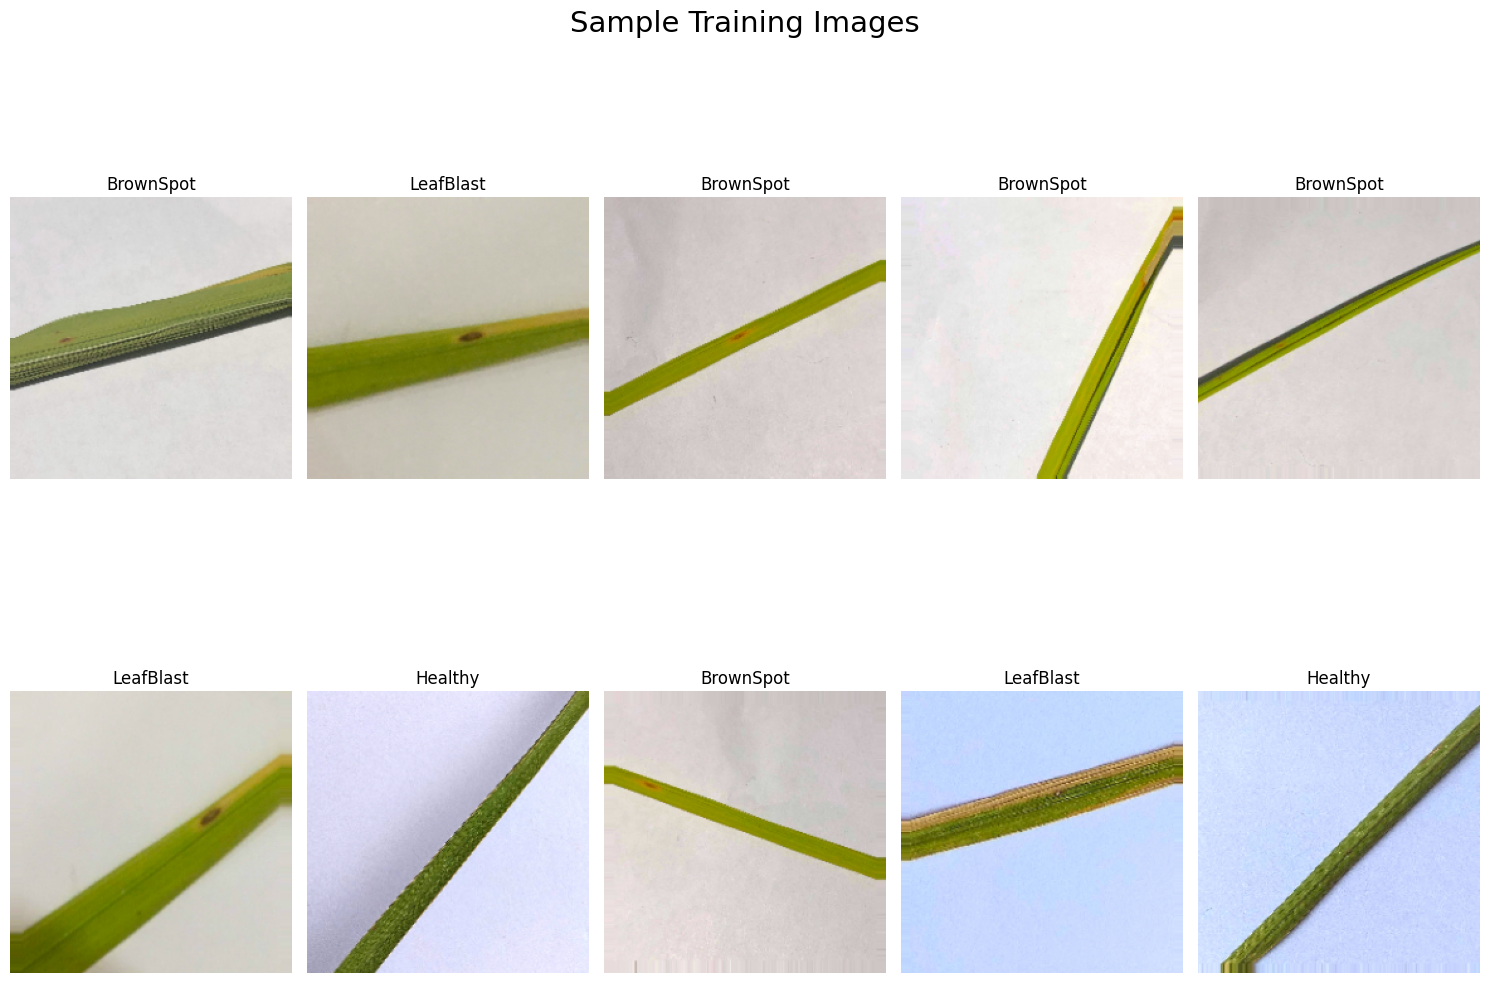

In [86]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

# Training a CNN Model

In [87]:
input_shape = (224, 224, 3)
def create_model(input_shape):
    model = Sequential([
        Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, kernel_size=(5, 5), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(4, activation='softmax')
    ])
    
    return model

In [88]:
cnn_model = create_model(input_shape)

print(cnn_model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 220, 220, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 106, 106, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 53, 53, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 359552)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │    92,045,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,256,388 (351.93 MB)

 Trainable params: 92,256,388 (351.93 MB)

 Non-trainable params: 0 (0.00 B)

None


In [89]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

optimizer = Adam(learning_rate=0.0001)

cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [90]:
history = cnn_model.fit(train_generator, epochs=25, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/25
5/5 - 11s - 2s/step - accuracy: 0.2750 - loss: 2.3986 - val_accuracy: 0.2500 - val_loss: 1.5250 - learning_rate: 1.0000e-04
Epoch 2/25
5/5 - 6s - 1s/step - accuracy: 0.2875 - loss: 1.4696 - val_accuracy: 0.2857 - val_loss: 1.3802 - learning_rate: 1.0000e-04
Epoch 3/25
5/5 - 6s - 1s/step - accuracy: 0.3500 - loss: 1.2478 - val_accuracy: 0.4107 - val_loss: 1.2654 - learning_rate: 1.0000e-04
Epoch 4/25
5/5 - 6s - 1s/step - accuracy: 0.6125 - loss: 1.0759 - val_accuracy: 0.1607 - val_loss: 1.3501 - learning_rate: 1.0000e-04
Epoch 5/25
5/5 - 10s - 2s/step - accuracy: 0.7250 - loss: 0.8901 - val_accuracy: 0.1607 - val_loss: 1.3981 - learning_rate: 1.0000e-04
Epoch 6/25
5/5 - 6s - 1s/step - accuracy: 0.7875 - loss: 0.7440 - val_accuracy: 0.1786 - val_loss: 1.5699 - learning_rate: 1.0000e-04
Epoch 7/25
5/5 - 7s - 1s/step - accuracy: 0.7875 - loss: 0.6234 - val_accuracy: 0.1429 - val_loss: 2.0338 - learning_rate: 1.0000e-04
Epoch 8/25
5/5 - 6s - 1s/step - accuracy: 0.8375 - loss: 0.5

# Plotting the Model Metrics

In [91]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['learning_rate']

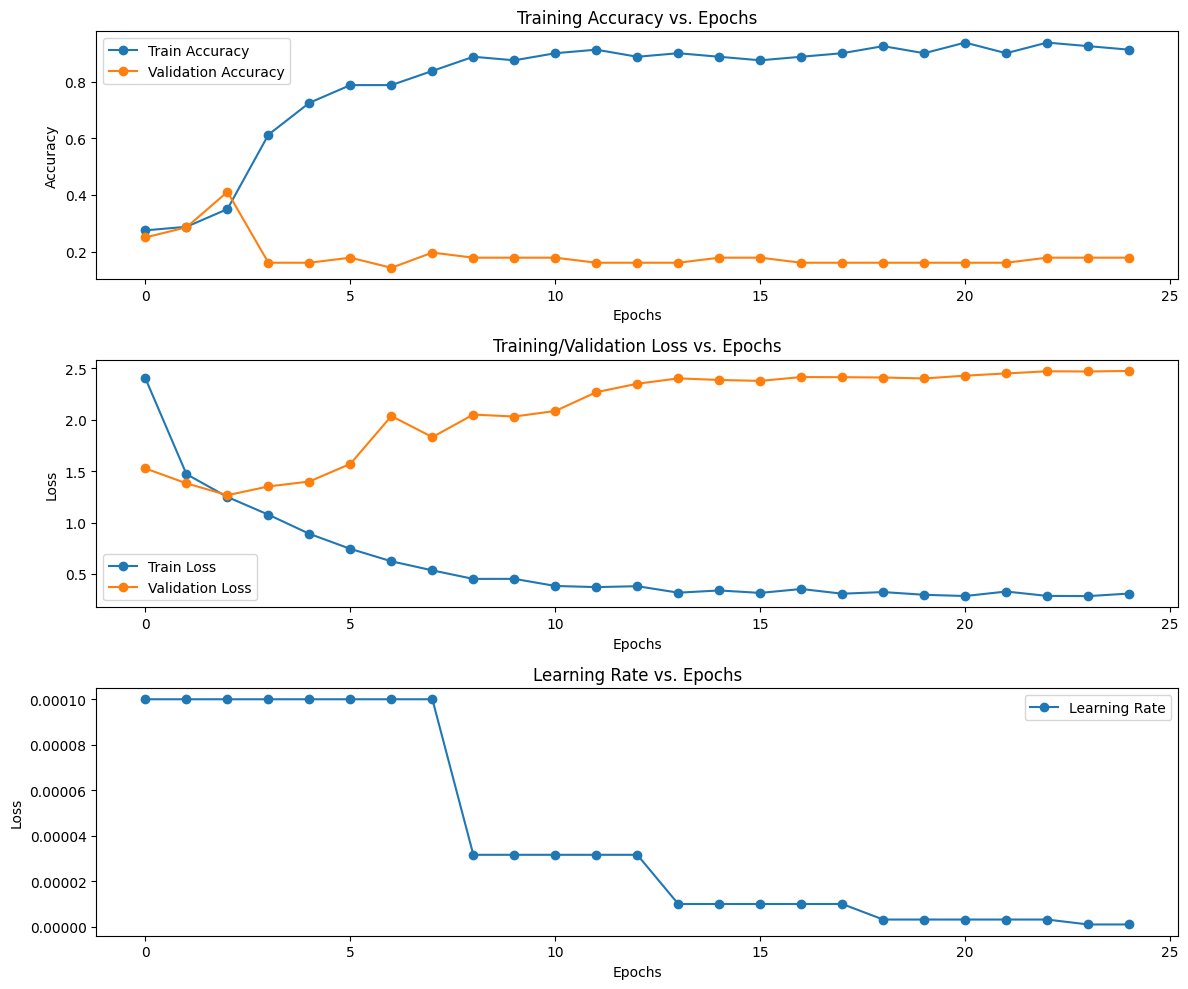

In [92]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

# Testing the Model on Test Set

In [93]:
test_dataset = '/kaggle/input/riceleafs2/RiceLeafs2/validation'

In [94]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=16,
                                                 target_size = (224, 224),
                                                 class_mode='categorical')

Found 56 images belonging to 4 classes.


# Model Prediction on the Test Dataset

In [95]:
predictions = cnn_model.predict(test_generator)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step


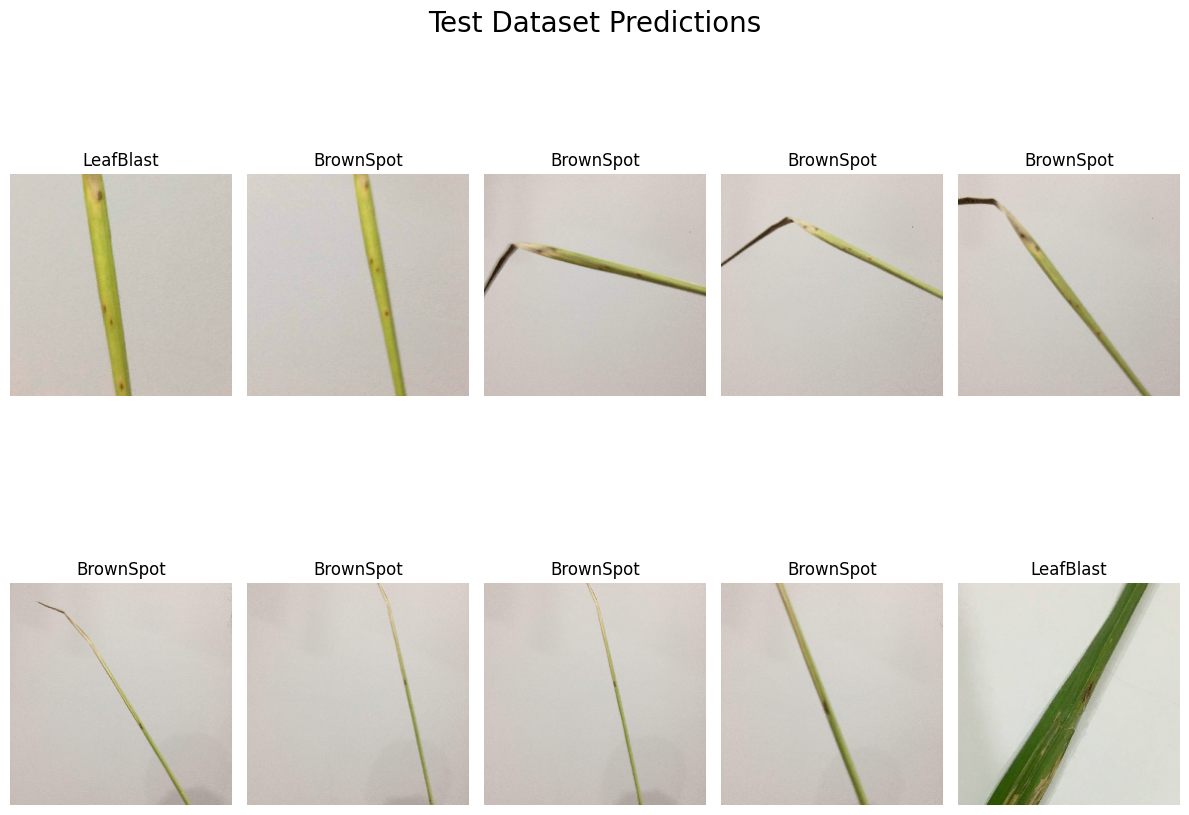

In [96]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [97]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=16)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - accuracy: 0.2777 - loss: 2.2725


In [98]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     2.4720184803009033
Test Accuracy: 0.1785714328289032


# Plotting the Classification Metrics

In [99]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

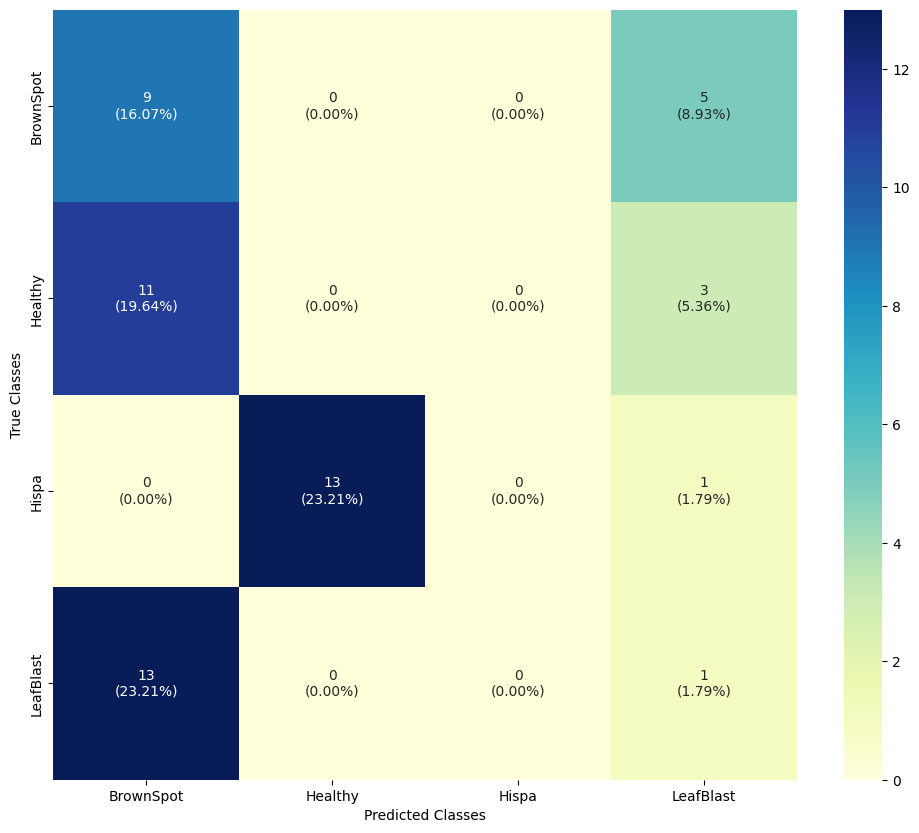

In [100]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(cf_mtx.shape[0], cf_mtx.shape[1])

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [101]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

   BrownSpot       0.27      0.64      0.38        14
     Healthy       0.00      0.00      0.00        14
       Hispa       0.00      0.00      0.00        14
   LeafBlast       0.10      0.07      0.08        14

    accuracy                           0.18        56
   macro avg       0.09      0.18      0.12        56
weighted avg       0.09      0.18      0.12        56



# Wrong Predictions

In [102]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [103]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

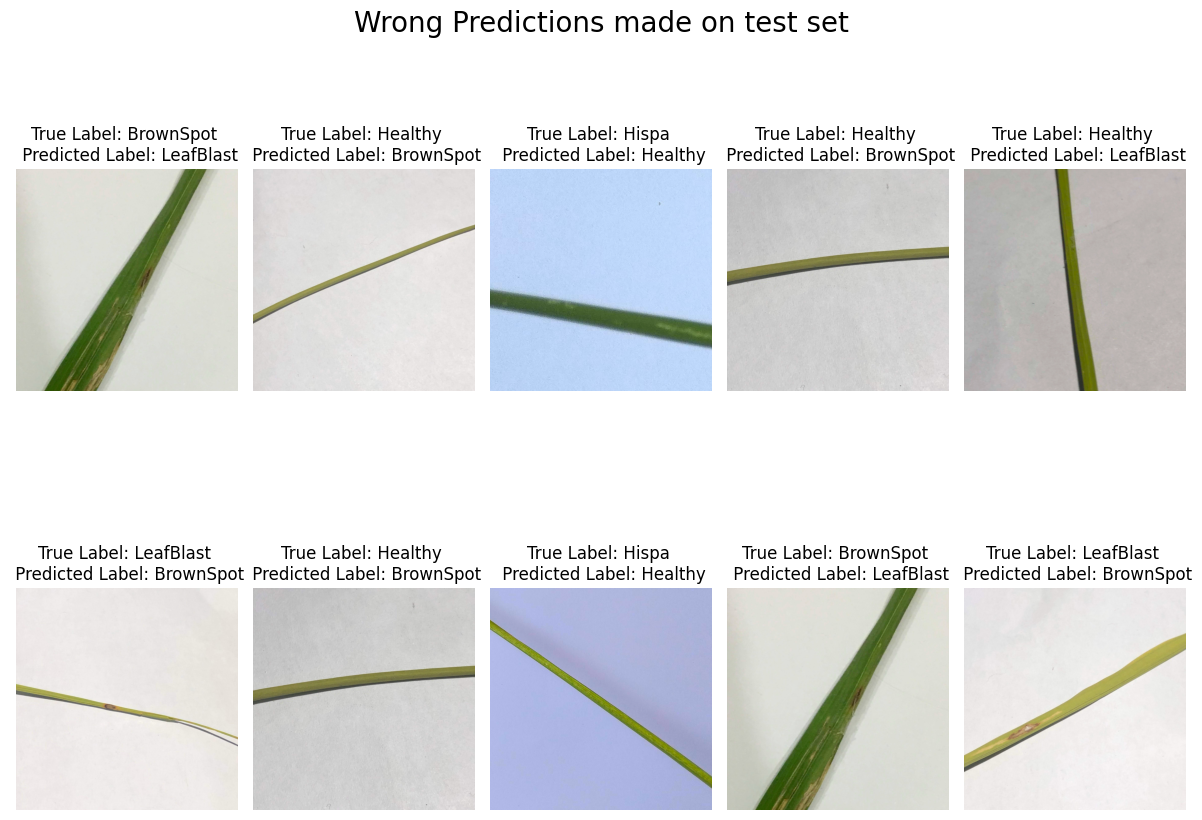

In [104]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()